In [1]:
# importing libraries and set standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams['figure.figsize'] = 21, 15
plt.rcParams['xtick.labelsize']=65
plt.rcParams['ytick.labelsize']=65
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'figure.autolayout': False})
plt.rcParams['axes.linewidth'] = 5
plt.rcParams['font.family'] = 'Arial'

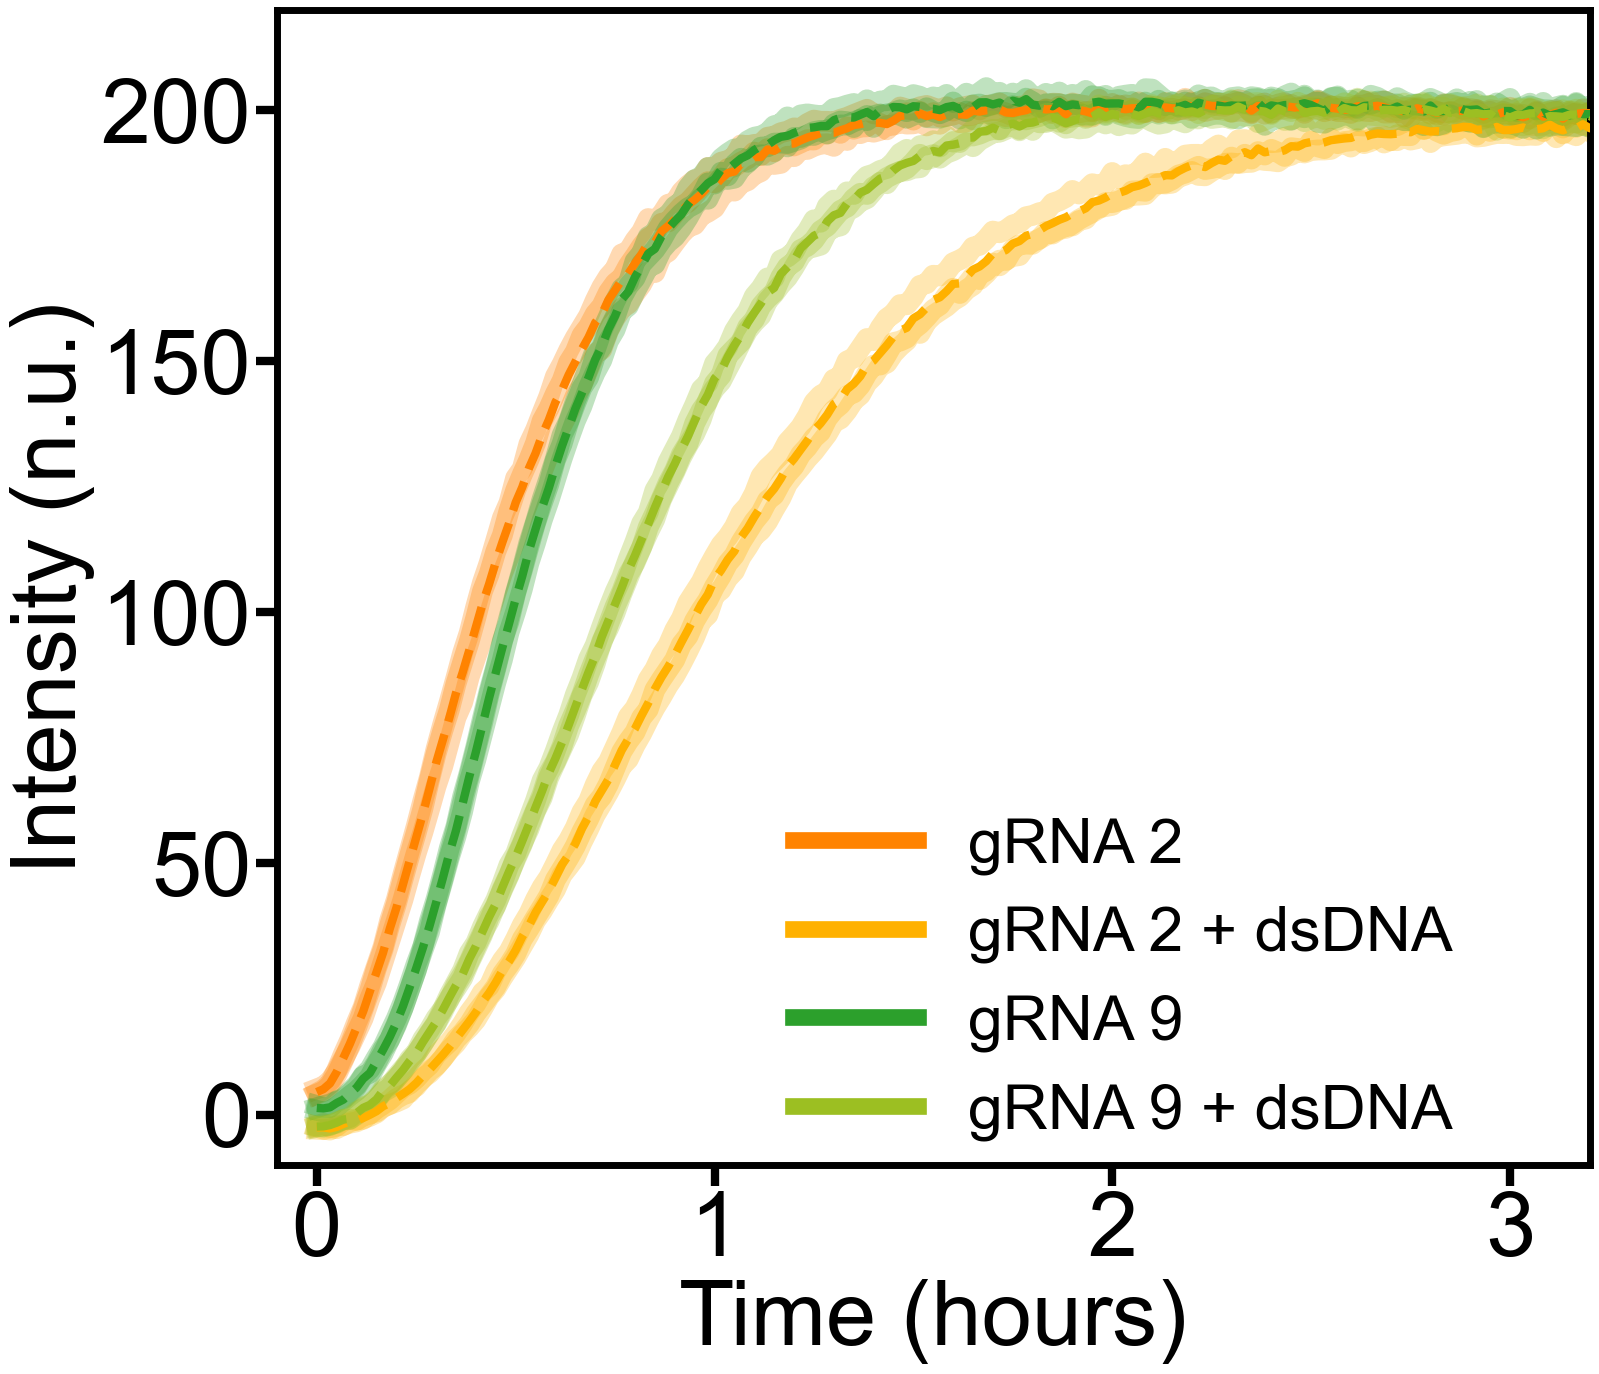

In [3]:
# Excel-Datei laden
df = pd.read_excel("Figure1.xlsx")
time = df["time"] / 3600

# Konfiguration für jede Bedingung
plot_config = [
    {
        "cols": ["gRNA 2", "gRNA 2.1", "gRNA 2.2"],
        "label": "gRNA 2",
        "color": "#ff8300",
    },
    {
        "cols": [
            "gRNA 2 0.2 µM DNA N200",
            "gRNA 2 0.2 µM DNA N200.1",
            "gRNA 2 0.2 µM DNA N200.2",
        ],
        "label": "gRNA 2 + dsDNA",
        "color": "#ffb100",
    },
    {
        "cols": ["gRNA 9", "gRNA 9.1", "gRNA 9.2"],
        "label": "gRNA 9",
        "color": "#2ca02c",
    },
    {
        "cols": [
            "gRNA 9 0.2 µM DNA N200",
            "gRNA 9 0.2 µM DNA N200.1",
            "gRNA 9 0.2 µM DNA N200.2",
        ],
        "label": "gRNA 9 + dsDNA",
        "color": "#9cbf22",
    },
]

# Plot
fig, ax = plt.subplots()

for cfg in plot_config:
    # Plot all technical replicates as thick, semi-transparent lines
    for col in cfg["cols"]:
        ax.plot(
            time,
            df[col],
            linewidth=15,
            alpha=0.3,
            color=cfg["color"],
            zorder=1
        )
    # Plot the average as a dashed line
    mean_values = df[cfg["cols"]].mean(axis=1)
    ax.plot(
        time,
        mean_values,
        label=cfg["label"],
        color=cfg["color"],
        linewidth=6,
        linestyle='--',
        zorder=3
    )

# Custom legend: solid lines only
custom_legend = [
    Line2D([0], [0], color=cfg["color"], lw=12, label=cfg["label"])
    for cfg in plot_config
]

# Axes styling
ax.set_xlim([-0.1, 3.2])
ax.set_ylim([-10, 220])
ax.tick_params(axis='both', which='major', length=15, width=6)

ax.set_xlabel('Time (hours)', fontsize=65)
ax.set_ylabel('Intensity (n.u.)', fontsize=65)

# Custom legend with solid lines
ax.legend(
    handles=custom_legend,
    loc='upper left',
    bbox_to_anchor=(0.35, 0.35),
    fontsize=45,
    frameon=False
)

# Adjust layout to make space for the legend
plt.subplots_adjust(right=0.75)

# Save and show the plot
plt.savefig('Figure1-kinetics-teaser.svg', format='svg', dpi=300)
plt.show()


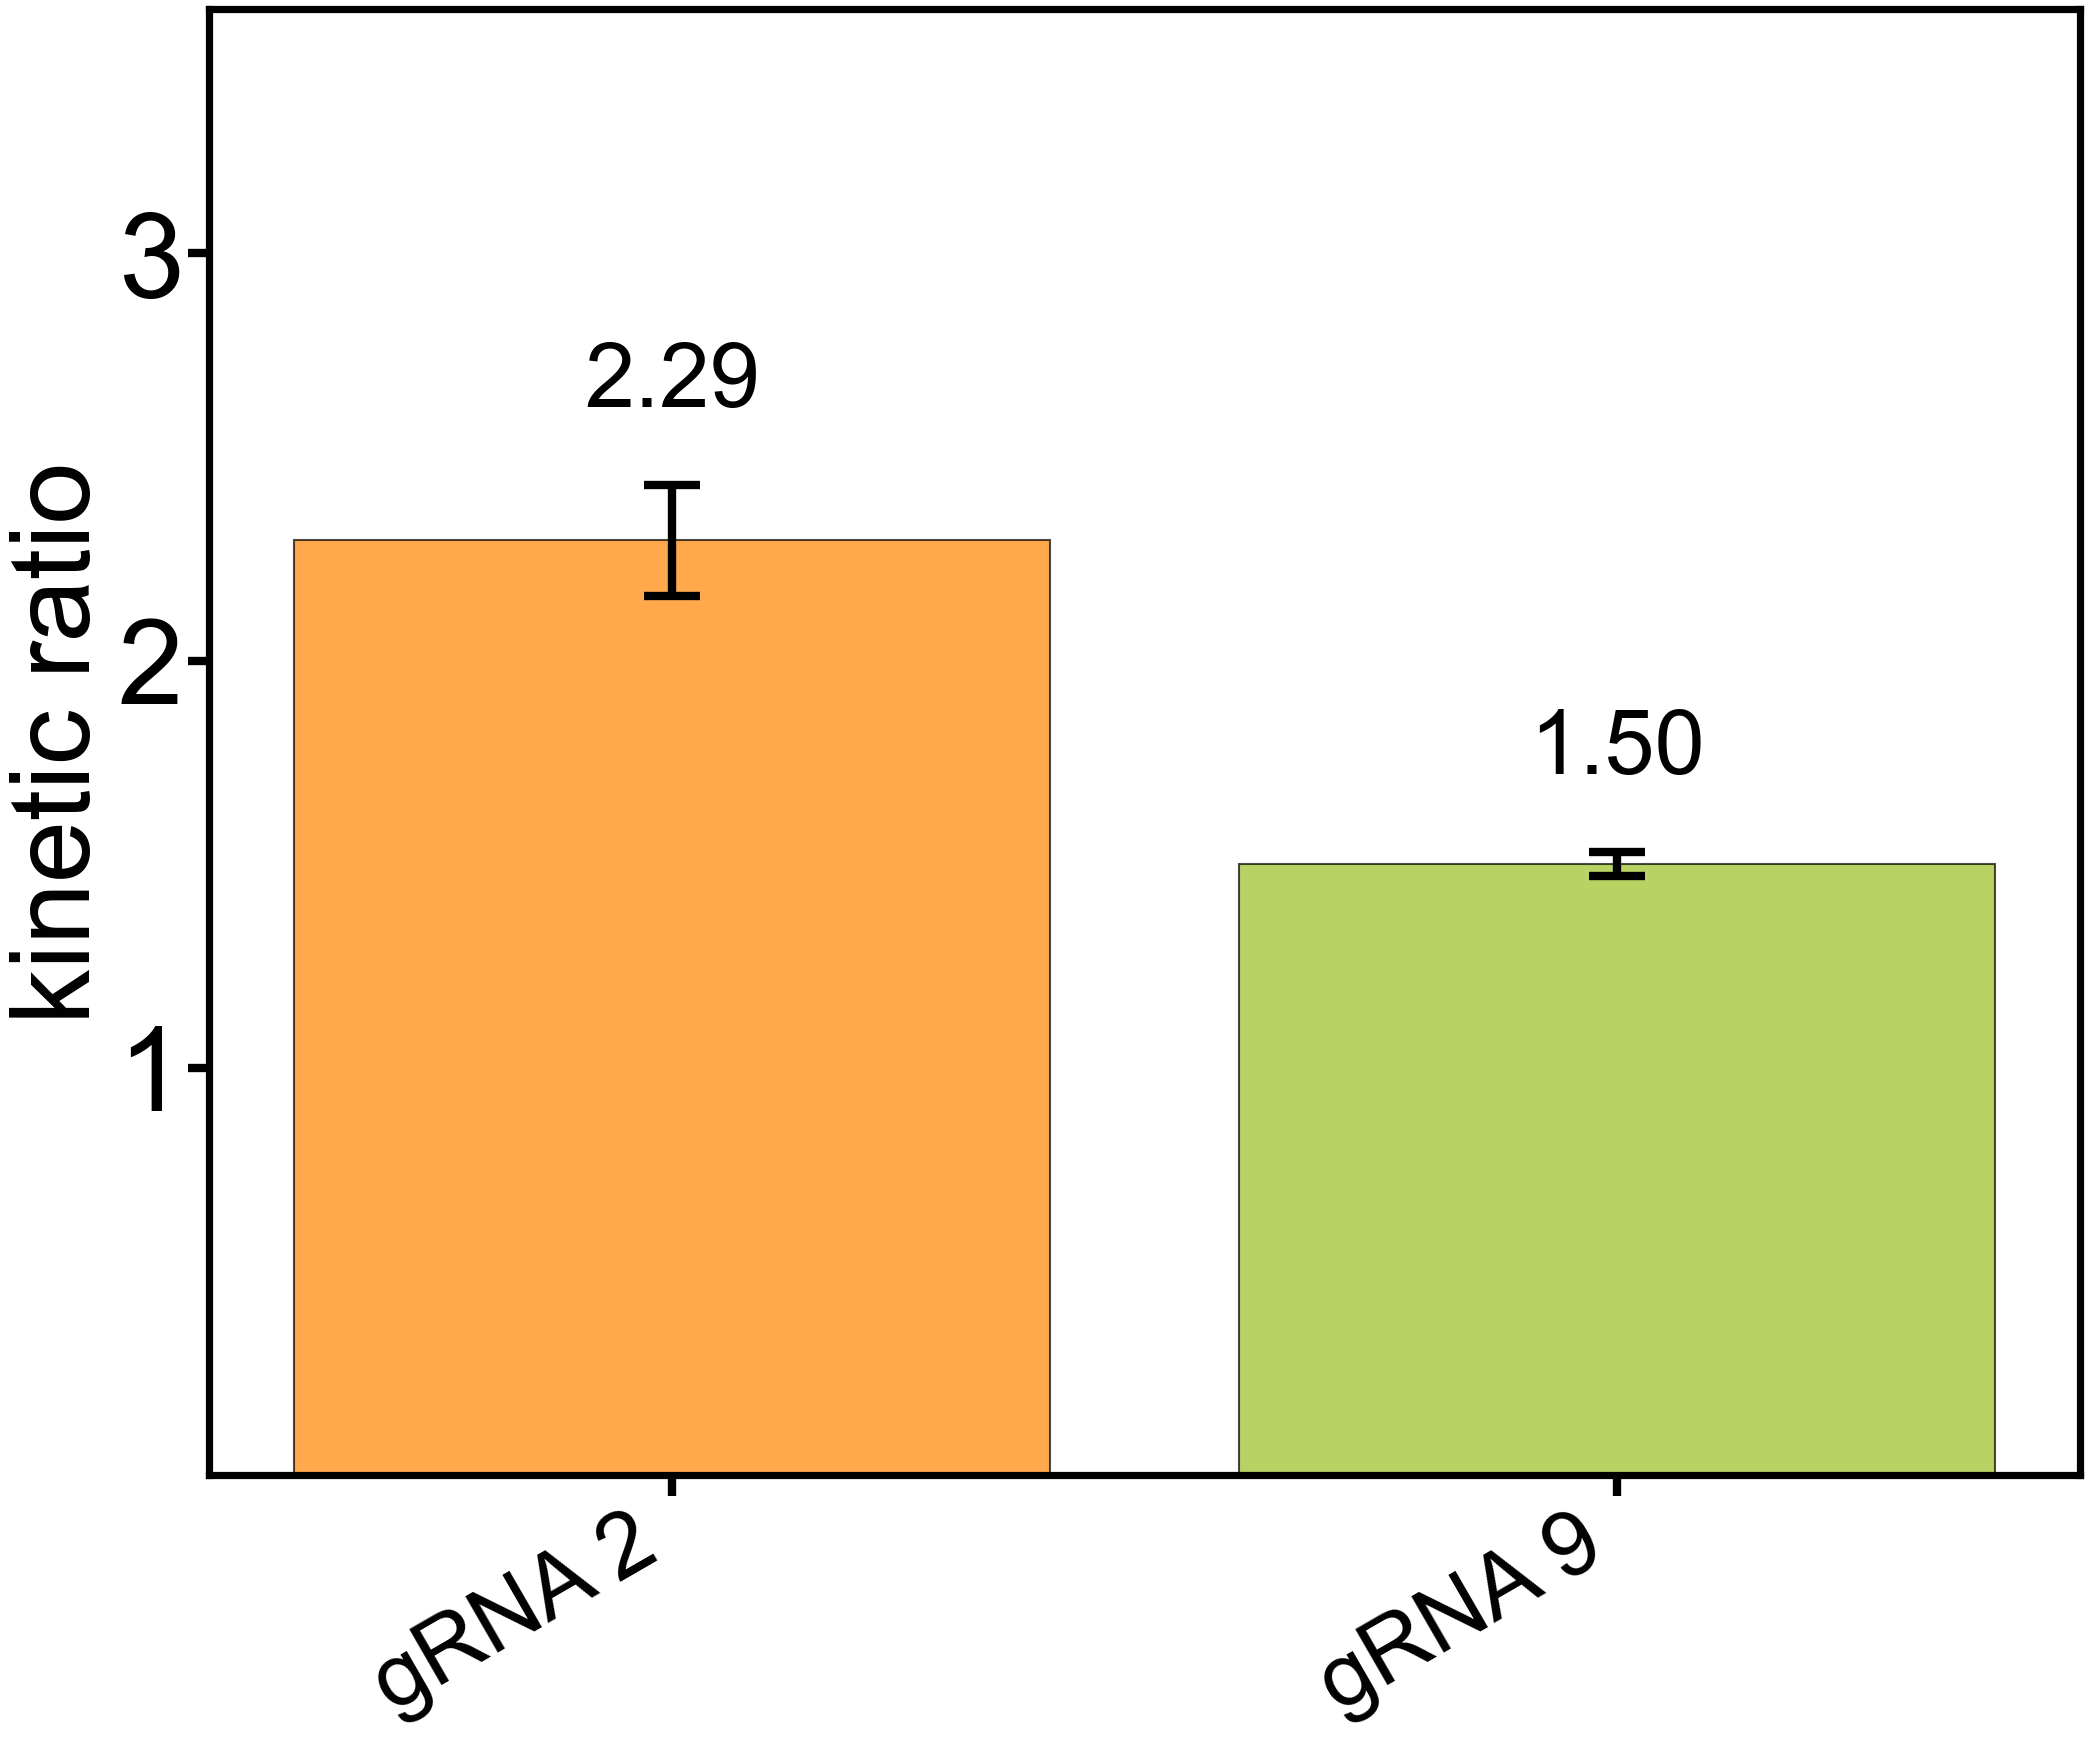

In [5]:
# Load the Excel file
df = pd.read_excel("Figure1.xlsx")
time = df["time"]

# Define condition pairs (triplicates)
condition_pairs = {
    "gRNA 2": {
        "ref": ["gRNA 2", "gRNA 2.1", "gRNA 2.2"],
        "rna": ["gRNA 2 0.2 µM DNA N200", "gRNA 2 0.2 µM DNA N200.1", "gRNA 2 0.2 µM DNA N200.2"]
    },
    "gRNA 9": {
        "ref": ["gRNA 9", "gRNA 9.1", "gRNA 9.2"],
        "rna": ["gRNA 9 0.2 µM DNA N200", "gRNA 9 0.2 µM DNA N200.1", "gRNA 9 0.2 µM DNA N200.2"]
    }
}
# Compute t100 ratios using all cross comparisons
results = {}

for label, pair in condition_pairs.items():
    # Get t100 times for ref and rna
    ref_times = []
    rna_times = []

    for col in pair["ref"]:
        exceed = df[df[col] > 100]
        if not exceed.empty:
            ref_times.append(exceed.iloc[0]["time"])

    for col in pair["rna"]:
        exceed = df[df[col] > 100]
        if not exceed.empty:
            rna_times.append(exceed.iloc[0]["time"])

    # Compute all pairwise ratios
    ratios = []
    for d in rna_times:
        for r in ref_times:
            if r > 0:
                ratios.append(d / r)

    # Store mean and std
    if ratios:
        results[label] = {
            "mean": np.mean(ratios),
            "std": np.std(ratios, ddof=1),  # sample std
            "values": ratios
        }

# Prepare data for plotting
labels = list(results.keys())
means = [results[label]["mean"] for label in labels]
stds = [results[label]["std"] for label in labels]
colors = ['#ff8300', '#9cbf22']

# Create the bar plot
fig, ax = plt.subplots(figsize=(21, 17.5))

bars = ax.bar(
    labels,
    means,
    yerr=stds,
    capsize=20,
    color=colors,
    edgecolor='black',
    linewidth=1.5,
    alpha=0.7,
    error_kw={"elinewidth": 6, "capthick": 6}  # thick error bars
)

# Annotate bar values above error bars
for bar, mean, std in zip(bars, means, stds):
    height = mean + std
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.15,
        f"{mean:.2f}",
        ha='center',
        va='bottom',
        fontsize=65,
        fontweight='bold'
    )

# Styling
plt.xticks(rotation=30, ha='right', fontsize=65)
plt.yticks(fontsize=65)
plt.ylabel("kinetic ratio", fontsize=80)
ax.set_ylim([0, 3.6])
ax.set_yticks([1, 2, 3])
ax.tick_params(axis='y', labelsize=85)
ax.tick_params(axis='both', which='major', length=15, width=6)
plt.rcParams['axes.linewidth'] = 5.2

plt.tight_layout()
plt.savefig("Figure1-bars.svg", format="svg", dpi=300)
plt.show()